# Task C
Within this task, we will use the network built from task A. Here each node will be a `username`, an edge can only exist iff 2 nodes has the commented at the same `page_name` and `thread_subject`

Within this code it was aimed to find out the following
- Unusual activity
    - Define a criteria that says if the node has been involved in unusual activity aka commenting more than usual on the same day.
    - Find nodes that comments more than usual, these are the infected nodes
- Similarity Measure
    - Define a measure that checks if the behaviour of a node has or has not propagated to other neighbouring nodes
- Propagation
    - For each of the nodes if they are risky show how plausible it is that it has propagated
- Priority List

In [6]:
import networkx as nx
from taska import parseWikiData
from helpers import get_2_semi_random_nodes, calculate_stats, calculate_jaccard_similarity
from graph_helpers import display_graph, display_histogram, colours, get_colour, colours_with_label, colour_count
import csv
import matplotlib.pyplot as plt

## Loading dataset

In [7]:
datasets = ['PROPERTIES_FOR_DELETION_SML.csv', 'WIKIPROJECTS_MED.csv','USERS_LRG.csv',]
path = 'datasets/'
networks = [parseWikiData(path + datasets[i]) for i in range(len(datasets))]

network = 0
G = networks[network]

## Unusual activity
This will be when someone is commenting more than unusual, so let's take a look at the statistics of the graph.

In [8]:
stats = calculate_stats(G)
print(f"There is a total of {len(G.nodes())} nodes")
print(f"There is a total of {len(G.edges())}")
print(f"The mean degree of the graph is {stats['mean_degree']}")
print(f"The median degree of the graph is {stats['median_degree']}")
print(f"The max degree of the graph is {stats['max_degree']}")

There is a total of 739 nodes
There is a total of 13530
The mean degree of the graph is 36.617050067659
The median degree of the graph is 23
The max degree of the graph is 478


The variation here is great, most of the graphs the median is 1 while the mean is somewhat greater because of the max degree of the node.
Some users will surely be hyperactive in the chats, therefore you can't say that a node is suspicious if it's greater than the mean or median.The measure here will be 1/4 of the max degree, just to assure that the user surly is suspicious. 
Then we can extract some nodes from the graph with a degree above the `degree_threshold`. 

In [9]:
degree_threshold = int(stats['max_degree']/6)
infected_nodes = get_2_semi_random_nodes(graph=G, threshold=degree_threshold)
print(f"The editors currently marked as infected are {infected_nodes}")
print(f"{infected_nodes[0]} has a degree of {G.degree(infected_nodes[0])}")
print(f"{infected_nodes[1]} has a degree of {G.degree(infected_nodes[1])}")

The editors currently marked as infected are ['Jasper Deng', 'Multichill']
Jasper Deng has a degree of 90
Multichill has a degree of 254


## Similarity measure
Two measured are used together to define a similarity measure between the two nodes. This measure is called transmission risk as later on in the code we use this to define if the behaviour has propagated to neighbouring nodes. 

### Jaccard Similarity
The first measure that's used is jaccard similarity. Jaccard similarity can be used to compare two groups to see how much they have in common. In our case we want to see if any of the infected nodes has similarities with their neighbours to define if they share the same trates as them to see if they also are indeed trolling. The formula for jaccard is defined below
$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$
In our case A is the infected nodes neighbours and B is the selected nodes neighbours.
It should also be mentioned that the closer the  Jaccard similarity is to 1, the more similar the nodes are, however if it's closer to 0, the 2 nodes doesn't have much in common. 

### Shortest path
The shortest path is also considered as we don't only look on the nodes direct neighbours we look at all the nodes in the graph. 

### Transmission risk
The general transmission risk is then calculated by doing.
$$
similarity=\frac{jaccard_similarity}{shortest_path_length}
$$ 
However a default value of 0 is returned if the degree of the node is below a degree threshold, as if it's below this threshold it means that the node e.g. only has one node, therefore shouldn't be marked as suspicious.

In [10]:
def calculate_transmission_risk(graph: nx.graph,
                                infected_node: str,
                                susceptible_node: str,
                                threshold: int) -> float:
    if nx.has_path(graph, infected_node, susceptible_node):
        susceptible_node_neighbours = list(graph.neighbors(susceptible_node))
        # if the degree is lower than a threshold the node isn't susceptible
        if len(susceptible_node_neighbours) < threshold:
            return 0.0
        infected_node_neighbours = list(graph.neighbors(infected_node))
        path_length = nx.shortest_path_length(graph, infected_node, susceptible_node)
        similarity = calculate_jaccard_similarity(infected_node_neighbours,
                                                  susceptible_node_neighbours)
        risk = similarity / path_length
        return risk
    else:
        return 0.0  # No path, no risk

## Propagation
We need to calculate the transmission risk for all nodes that are risky, these are the nodes that has a risk greater than 0.

In [11]:
def get_risk_scores_of_valid_nodes(graph: nx.graph,
                                   initially_infected: list[str],
                                   susceptible_editors: list[str],
                                   threshold: int) -> dict:
    transmission_risk_scores = {}
    for infected in initially_infected:
        for susceptible in susceptible_editors:
            risk = calculate_transmission_risk(graph, infected, susceptible, threshold)
            if risk == 0:
                pass
            elif risk not in transmission_risk_scores:
                transmission_risk_scores[susceptible] = risk
            else:
                current_risk = transmission_risk_scores[susceptible]
                transmission_risk_scores[susceptible] = max(current_risk, risk)
    return transmission_risk_scores

all_nodes = [node for node in G.nodes() if node not in infected_nodes]
risky_nodes = get_risk_scores_of_valid_nodes(G, infected_nodes, all_nodes, stats['median_degree'])

Let's make a new graph with only the nodes that are risky.

In [12]:
def generate_risk_graph(old_graph: nx.graph, nodes: dict, nodes_infected: list) -> nx.graph:
    graph = nx.Graph()
    graph.add_nodes_from(nodes_infected, color=colours[0])
    node_keys = set(nodes.keys())
    appended_nodes = set()
    for node in nodes:
        graph.add_node(node, color=get_colour(nodes[node]))
    for node in node_keys:
        for infected in nodes_infected:
            shortest_path = nx.shortest_path(old_graph, source=infected, target=node)
            if len(shortest_path) == 2:
                graph.add_edge(shortest_path[0], shortest_path[1])
            else:
                for i in range(len(shortest_path) - 1):
                    next_elem = shortest_path[i + 1]
                    if (next_elem not in node_keys
                            and next_elem not in nodes_infected
                            and next_elem not in appended_nodes):
                        appended_nodes.add(next_elem)
                        graph.add_node(shortest_path[i + 1], color=colours[6])
                    graph.add_edge(shortest_path[i], shortest_path[i + 1])
    return graph


Let's have a look on how the nodes are connected and their belonging similarity measure.
In most instances here there will be loads of nodes, so the histogram will be a better representation of the similarity distribution.
The darker red color and the greater the similarity the more likely it is that node possibly has been trolling.  

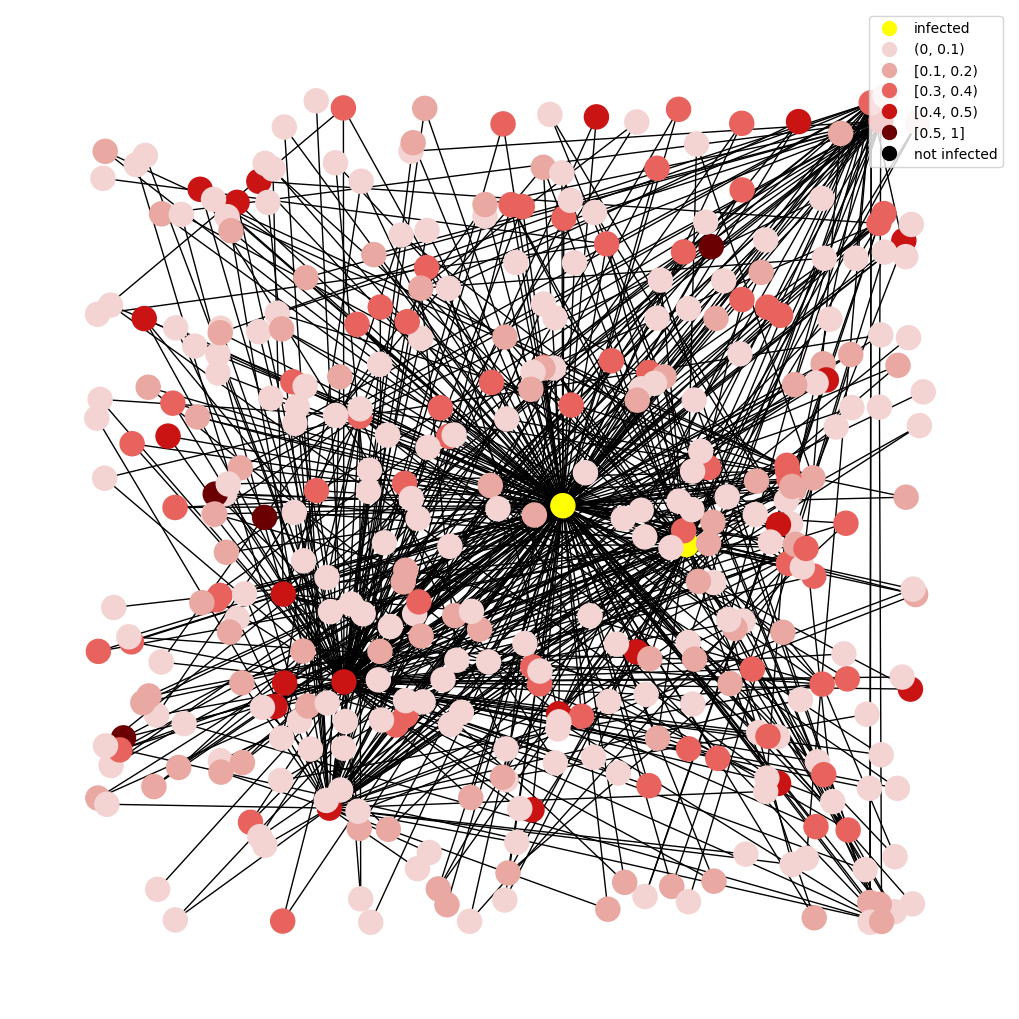

In [13]:
new_graph = generate_risk_graph(G, risky_nodes, infected_nodes)
display_graph(new_graph)

We can also have a look on the distribution between the different similarity measure ranges as a histogram. 
We can see in most instances that most of the nodes aren't that similar to any of the infected nodes. These are then probably not trolls either.

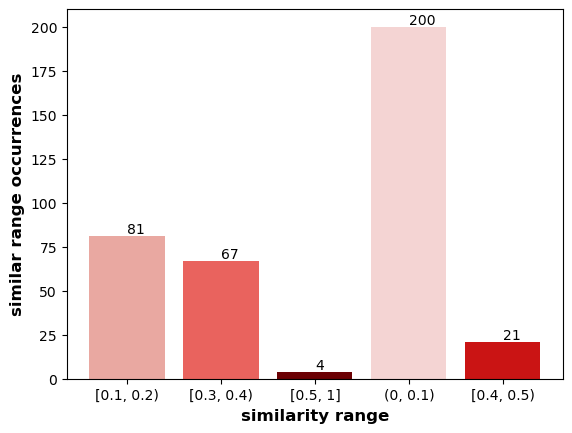

In [14]:
display_histogram(new_graph)

## Propagation
The way we can make a priority list is to sort the list of risky nodes with respect to the similarity measure.

In [15]:
sorted_data = sorted(risky_nodes.items(), key=lambda item: item[1], reverse=True)

print("The 10 first nodes that are the riskiest are:")
for node in sorted_data[:10]:
    print(node)

# saving the data as a csv file
with open('analysed_nodes.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['username', 'similarity'])
    for key, value in sorted_data:
        writer.writerow([key, value])

The 10 first nodes that are the riskiest are:
('Deryck Chan', 0.412987012987013)
('Jheald', 0.4125)
('Strakhov', 0.4111111111111111)
('Jklamo', 0.40782122905027934)
('JAn Dudík', 0.39501779359430605)
('Esquilo', 0.38977635782747605)
('PKM', 0.37809187279151946)
('Liuxinyu970226', 0.3702127659574468)
('Nomen ad hoc', 0.3619047619047619)
('Matěj Suchánek', 0.36065573770491804)


## Comparison 
We want to get the statistics of multiple runs for further analysis. The steps to achieve this is o:
1. Run 10 instances of the algorithm defined above and save the risk_graph.
2. Make an average for each of the similarity ranges
3. Display the histogram

### Run multiple runs

In [ ]:
# Run 10 instances for each of the 3 networks

network: int = 0
graphs: dict = {}
iterations: int = 10

for i in range(3):
    G = networks[i]
    stats = calculate_stats(G)
    degree_threshold = int(stats['max_degree']/8)
    graphs[i] = []   
    for j in range(iterations):
        infected_nodes = get_2_semi_random_nodes(graph=G, threshold=degree_threshold)
        all_nodes = [node for node in G.nodes() if node not in infected_nodes]
        risky_nodes = get_risk_scores_of_valid_nodes(G, infected_nodes, all_nodes, stats['median_degree'])
        risk_graph = generate_risk_graph(G, risky_nodes, infected_nodes)
        graphs[i].append(colour_count(risk_graph))

### Average similarity 

In [ ]:
averages = {}

# Sum the values for each unique colour for each network
for outer_key, inner_list in graphs.items():
    averages[outer_key] = {}
    for inner_dict in inner_list:
        for color, count in inner_dict.items():
            if color not in averages[outer_key]:
                averages[outer_key][color] = count
            else:
                current_sum = averages[outer_key][color]
                new_count = current_sum + count
                averages[outer_key][color] = new_count

# Take the average for each colour within each network
for i in averages:
    for j in averages[i]:
        averages[i][j] = int(averages[i][j]/iterations)
    

### Plotting similarity ranges for the runs

In [ ]:
colors = list(colours_with_label.values())[1:-1]

values_0 = list(averages[0].values())
values_1 = list(averages[1].values())
values_2 = list(averages[2].values())

fig, ax = plt.subplots(figsize=(15,6))
bar_width = 0.25
index = range(len(colors))

bar1 = ax.bar(index, values_0, bar_width, color="red", label=f'{(datasets[0][:-4])}')
bar2 = ax.bar([i + bar_width for i in index], values_1, bar_width, color="green", label=f'{datasets[1][:-4]}')
bar3 = ax.bar([i + 2*bar_width for i in index], values_2, bar_width, color="blue", label=f'{datasets[2][:-4]}')


ax.set_xlabel('Similarity Range')
ax.set_ylabel('similar range occurrences')
ax.set_title(f'Average similar range occurrences for 10 runs')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(colors)
ax.legend()

for bar in bar1 + bar2 +bar3:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., 1.01*height,
            '%d' % int(height), ha='center', va='bottom')

plt.show()